In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import umap
import shap
import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

In [2]:
#ml imports
from tune_sklearn import TuneSearchCV
from sklearn import metrics, model_selection
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
#tensorflow imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [3]:
df = pd.read_csv('.\\data\\train.csv')

In [4]:
df_test = pd.read_csv('.\\data\\test.csv')

In [5]:
file = open('.//data/data_description.txt', 'r')

In [6]:
#with open('.//data/data_description.txt') as file:
#    text_data = file.readlines()
#for temp in text_data:
#    print(temp.strip())

In [7]:
#similar sounding column names to later compare/columns to possibly combine to avoid collinearity:
#Condition1, Condition2
#OverallQual, OverallCond
#YearBuilt,YearRemodAdd
#Exterior1st, Exterior2nd
#ExterQual, ExterCond
#BsmtFinSF1, BsmtFinType2, BsmntUnfSF, TotalBsmtSF
#BsmtFullBath, BsmtHalfBath
#FullBath, HalfBath
#All of the number and quality columns
#GarageCars, GarageArea
#GarageQual, GarageCond
#WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch
#MiscFeature, MiscVal

# Data Exploration/Data Preprocessing
### The label is the SalePrice column  
We want to explore the distribution of the label and explore correlation between feature variables. This is a dataset with a large amount of feature variables, so part of the challenge will be selecting the ones that are important for predicting the label. Additionally, data engineering to combine variables may be necessary for very similar features or the removal of any redundant features. We can also attempt to reduce dimensionality with PCA, and generally filter out variables with low variance or high correlation.  
  
For Data Preprocessing, inconsistencies, na values, and other issues will addressed alongside the exploration when it seems convenient.

In [8]:
#df.info()

In [9]:
#df.describe()

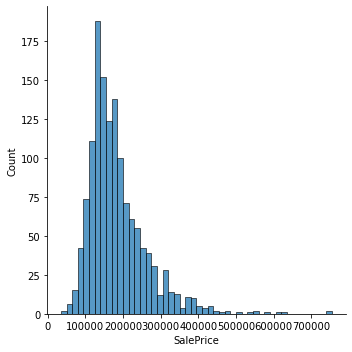

In [134]:
#Distribution plot of label, appears to be normally distributed with a few high outliers
sns.displot(data=df,x='SalePrice')

In [138]:
#Correlation with label
df.corr()['SalePrice'].sort_values(ascending=False).head(20)

SalePrice               1.000000
OverallQual             0.786212
GrLivArea               0.709795
GarageCars              0.636118
GarageArea              0.607210
TotalBsmtSF             0.602981
1stFlrSF                0.595994
FullBath                0.558644
TotRmsAbvGrd            0.541117
YearBuilt               0.507696
YearRemodAdd            0.505673
Foundation_PConc        0.491353
GarageYrBlt             0.486220
MasVnrArea              0.468083
Fireplaces              0.450939
ExterQual_Gd            0.439688
BsmtFinType1_GLQ        0.431882
Neighborhood_NridgHt    0.396770
BsmtFinSF1              0.373079
SaleType_New            0.356627
Name: SalePrice, dtype: float64

In [12]:
#check value_counts() of dimensions

OverallQual column: Rates the overal material and finish of the house
GrLivArea: Above grade (ground) living area square feet
GarageCars: Size of garage in car capacity
GarageArea: Size of garage in square feet


<AxesSubplot:>

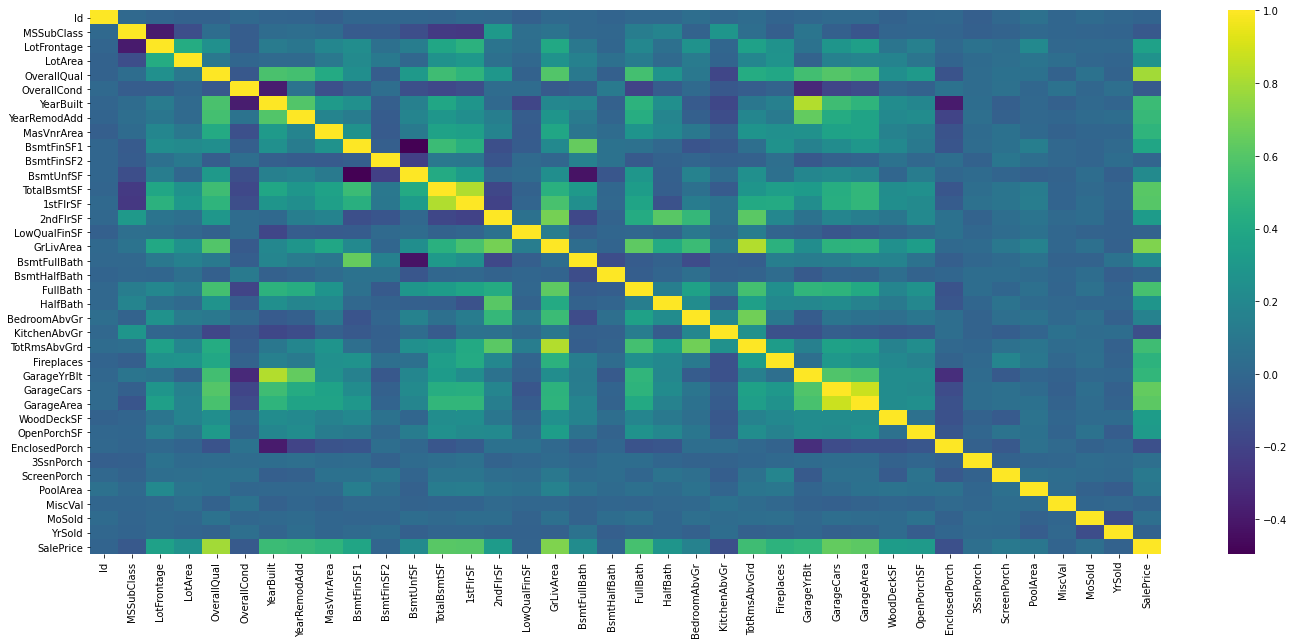

In [13]:
plt.figure(figsize=(24,10))
sns.heatmap(data=df.corr(),cmap='viridis')

We can try predicting based on a manual selection on some of these dimensions or we can use Principal Component Analysis to reduce the dimensionality of this data set and eliminate multicollinearity among the predictor variables. We'll try reducing the dimensions first

<AxesSubplot:>

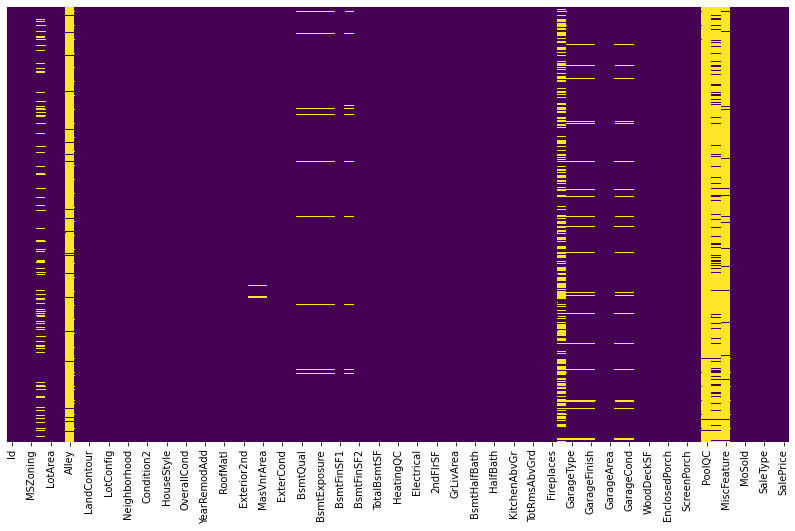

In [14]:
#Alley, PoolQC, Fence, MiscFeature are mostly empty. We can turn them into binary labels,
#or drop them completely.
plt.figure(figsize=(14,8))
sns.heatmap(df.isnull(),yticklabels=False, cbar=False, cmap='viridis')

# Data Preprocessing

In [15]:
#Alley
df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [16]:
df['Alley'] = df['Alley'].fillna(value='None')

In [17]:
#PoolQC, only 7 values so I will drop
df['PoolQC'].value_counts()

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

In [18]:
df.drop(columns='PoolQC',axis=1,inplace=True)

In [19]:
#Fence
df['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [20]:
#fillna for fence
df['Fence'] = df['Fence'].fillna(value='None')

In [21]:
#MiscFeature, less than 5 percent are filled, and shed does not seem like it would matter 
#while the value of the tennis court house likely has other dimensions that will account for it
df['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [22]:
df.drop(columns='MiscFeature',axis=1,inplace=True)

In [23]:
#Fireplaces is probably good enough without the fireplace quality column so we will drop it
df['Fireplaces'].value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

In [24]:
df.drop(columns='FireplaceQu',axis=1,inplace=True)

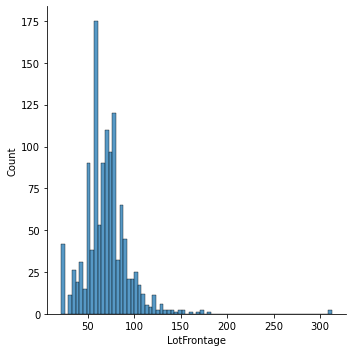

In [25]:
#LotFrontage
sns.displot(data=df,x='LotFrontage')

In [26]:
#fillna of LotFrontage, replace with 0
df['LotFrontage'] = df['LotFrontage'].fillna(value=0)

In [27]:
df.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

In [28]:
df = pd.get_dummies(data=df,columns=['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'], drop_first=True)

In [29]:
#quick drop of remaining NA rows, they represent less than 10% of data
df.dropna(inplace=True)

In [30]:
#remove label and Id column from PCA
df_pca = df.drop(labels='SalePrice',axis=1)

In [31]:
#standardize, fit, transform data
scaler = StandardScaler()

In [32]:
x_pca = scaler.fit_transform(df_pca)

In [33]:
#PCA with 20 components, roughly 10% of the original number of dimensions
pca = PCA(n_components=50)

In [34]:
pca.fit(x_pca)

PCA(n_components=50)

In [35]:
#transform into 20 principal components
x_pca = pca.transform(x_pca)

In [36]:
x_pca.shape

(1371, 50)

In [37]:
pca.components_

array([[-0.00372234,  0.00645879,  0.03809112, ..., -0.01241703,
        -0.06089321,  0.11203479],
       [-0.00236703,  0.11849904, -0.00110753, ..., -0.00283526,
        -0.03972576,  0.06006664],
       [ 0.00237805, -0.02789544,  0.0974859 , ...,  0.01135985,
        -0.02161294,  0.01302444],
       ...,
       [-0.02185178,  0.10175304,  0.02469448, ..., -0.14135494,
         0.01970047,  0.01644314],
       [ 0.02964881, -0.01124558, -0.15129207, ..., -0.00850362,
        -0.0671255 ,  0.04169384],
       [-0.06128672,  0.05563452,  0.08290664, ..., -0.07548819,
         0.03114438,  0.02369486]])

In [38]:
x_pca = pd.DataFrame(pca.components_,columns=df_pca.columns)

<AxesSubplot:>

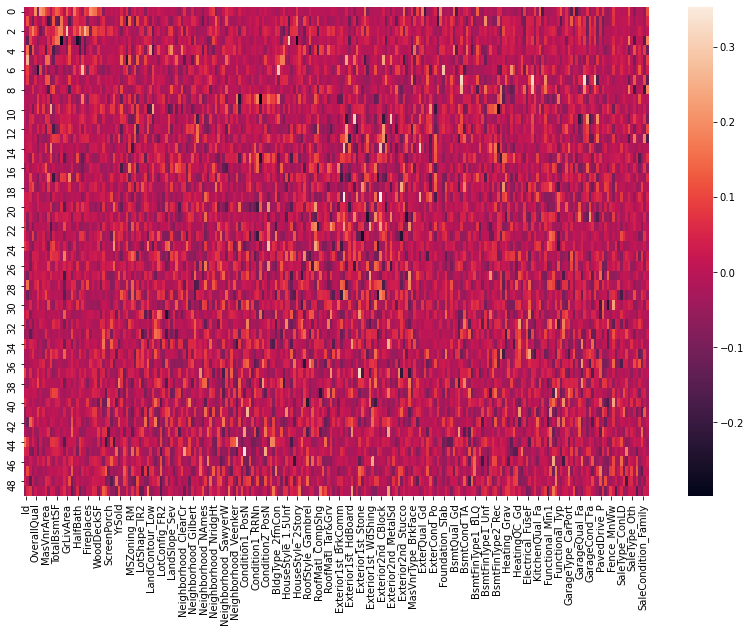

In [39]:
plt.figure(figsize=(14,9))
sns.heatmap(x_pca)

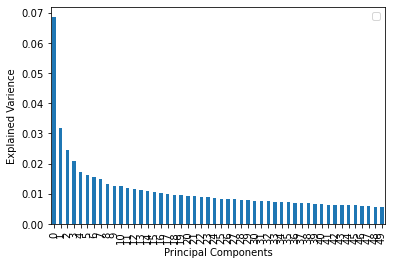

In [40]:
pd.DataFrame(pca.explained_variance_ratio_).plot.bar()
plt.legend('')
plt.xlabel('Principal Components')
plt.ylabel('Explained Varience');

In [41]:
#
#We can run build a simple prediction model on this first component and check our results 
pca.explained_variance_ratio_[0]
#x_pca[:1].stack().sort_values(ascending=False)

0.06859459754248144

The explained variance by the first principal vector is very low, so I will try to select features based on feature importance using a random forest regressor

In [42]:
rf = RandomForestRegressor(max_depth=20)

# The Data used for model training below.   
X will be all the dimensions  
y will be the label  
X_df is the scaled labels  

In [43]:
#need train test split, or a seperate variable to fit transform the label but not fit it
X = df.drop(labels=['SalePrice','Id'],axis=1)
y = df['SalePrice']
X_df = scaler.fit_transform(df.drop(labels=['SalePrice','Id'],axis=1))

In [44]:
rf.fit(X_df,y)

RandomForestRegressor(max_depth=20)

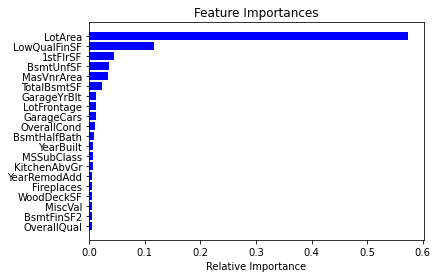

In [45]:
features = df.drop(labels='SalePrice',axis=1).columns
importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [46]:
np.corrcoef(x=df['OverallQual'],y=df['GrLivArea'])

array([[1.        , 0.59123769],
       [0.59123769, 1.        ]])

In [47]:
np.corrcoef(x=df['TotalBsmtSF'],y=df['BsmtFinSF1'])

array([[1.        , 0.51950515],
       [0.51950515, 1.        ]])

In [48]:
features = SelectFromModel(rf)

In [49]:
Fit = features.fit_transform(X_df,y)

In [50]:
print(Fit)

[[ 0.20624289 -0.21883609  0.6096228  ... -0.77069864  0.21560696
   1.1420165 ]
 [ 0.63470891 -0.10632348 -0.1346273  ...  1.58106361 -0.72343197
   1.1420165 ]
 [ 0.2919361   0.05510767  0.6096228  ... -0.77069864 -0.07688058
   1.1420165 ]
 ...
 [ 0.23480729 -0.16091655  0.6096228  ... -0.77069864  0.20021288
  -0.87564409]
 [ 0.2919361  -0.09487654 -0.8788774  ...  2.11770735 -0.72343197
  -0.87564409]
 [ 0.4918869  -0.07335239 -0.8788774  ...  5.03768062  0.32336552
  -0.87564409]]


In [51]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [52]:
#Test regression models
models = []
models.append(('LinR', LinearRegression()))
models.append(('SVR', SVR()))
models.append(('KNR', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor(max_depth=30)))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('XGR', XGBRegressor()))
models.append(('DT', DecisionTreeRegressor()))

LinR: 0.636931 (0.369156)
SVR: -0.050942 (0.028558)
KNR: 0.640661 (0.069700)
RF: 0.850391 (0.070124)
GBR: 0.882297 (0.075637)
XGR: 0.839867 (0.101170)
DT: 0.732125 (0.072793)


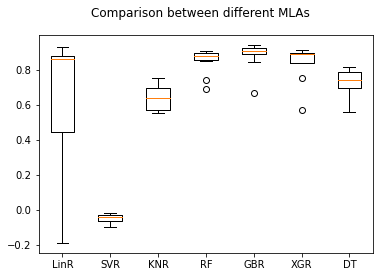

In [53]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Comparison between different MLAs')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Testing the best hyperparameters for RandomForestRegressor

In [54]:
#The RandomForestRegressor seems to be the best choice of algorithm along with GradientBoost
#We will use RandomizedSearchCV to find the best hyperparameters

#number of trees
n_estimators = [100,200,300,400,500,1000]

#max number of features at every split
max_features = ['auto','sqrt','log2']

#max levels in tree
max_depth=[10,20,30,40,50]
max_depth.append(None)

#min number of samples required to split a node
min_samples_split = [2,5,10,15,20]

#min samples per leaf
min_samples_leaf = [1,2,5,10,15]

#dictionary of parameters
grid_param = {'n_estimators': n_estimators,
             'max_features': max_features,
             'max_depth': max_depth,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf}

In [55]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf,
                              param_distributions= grid_param, n_iter = 500,
                              cv = 5, verbose = 2, n_jobs=-1)

In [56]:
#rf_random.fit(X, y)
#print(rf_random.best_params_)

In [57]:
#result: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 40}

Testing the best hyperparameters for GradientBoostingRegressor

In [58]:
#number of trees
n_estimators = [100,200,300]

#max levels in a tree
max_depth=[1,2,3,4,8,10,20,30]
max_depth.append(None)

#learning rates
learning_rate = [0.01,0.1,1,10]

#min number of samples required to split a node
min_samples_split = [2,5,10,15]

#min samples per leaf
min_samples_leaf = [1,2,3,4,5]

grid_param = {'n_estimators': n_estimators,
             'max_depth': max_depth,
             'learning_rate': learning_rate,
             'min_samples_split': min_samples_split,
             'min_samples_leaf': min_samples_leaf}

In [59]:
gbr = GradientBoostingRegressor()
gbr_random = RandomizedSearchCV(estimator=gbr,
                              param_distributions= grid_param, n_iter = 500,
                              cv = 5, verbose = 2, n_jobs=-1)

In [60]:
#gbr_random.fit(X,y)
#print(gbr_random.best_params_)

In [61]:
#best params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 2, 'learning_rate': 0.1}

Testing the best hyperparameters for XGBRegressor

In [62]:
#number of trees
n_estimators = [100,200,300,400]

#max levels in a tree
max_depth=[1,2,3,4,8,10]
max_depth.append(None)

#min child weight
min_child_weight = [1,3,5,7]

#learning rates
learning_rate = [0.01,.05,0.1,.5,1]

#gamma
gamma = [0.0,0.1,0.2,0.3,0.4,0.5]

#colsample
colsample_bytree = [.3,.4,.5,.6,.7]


grid_param = {'n_estimators': n_estimators,
             'max_depth': max_depth,
             'min_child_weight': min_child_weight,
             'learning_rate': learning_rate,
             'gamma': gamma,
             'colsample_bytree': colsample_bytree}

In [63]:
xgb = XGBRegressor()
xgb_random = RandomizedSearchCV(estimator=xgb,
                              param_distributions= grid_param, n_iter = 500,
                              cv = 5, verbose = 2, n_jobs=-1)

In [64]:
#xgb_random.fit(X,y)
#print(xgb_random.best_params_)

In [65]:
#best params 1: {'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.3}
#best params 2: {'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.0, 'colsample_bytree': 0.3}

In [66]:
#RF shap
rf = RandomForestRegressor(n_estimators= 200, min_samples_split= 2, min_samples_leaf= 1, 
                           max_features= 'auto', max_depth= 40)

In [67]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=40, n_estimators=200)

In [68]:
score = rf.score(X_test,y_test)
print(score)

0.8822793627937797


In [69]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

In [70]:
#df.corr()['SalePrice'].sort_values(ascending=False)

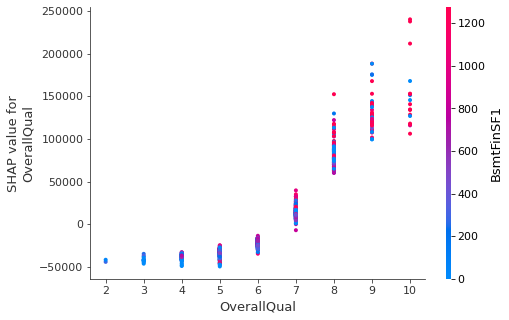

In [71]:
shap.dependence_plot(ind='OverallQual', shap_values=shap_values, features=X,interaction_index='BsmtFinSF1')

In [72]:
#Top 20 features by impact on model output are listed below
#shap.summary_plot(shap_values, X,max_display=40)

In [73]:
shap_vals_rf = pd.DataFrame(data = np.abs(shap_values), columns=X.columns)

In [74]:
shap_scores_rf = np.mean(shap_vals_rf).sort_values(ascending=False)

In [75]:
#train model on features up to the GarageQual_Gd label
rf_labels = shap_scores_rf[shap_scores_rf.values > 20]

In [76]:
rf_labels.index

Index(['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF',
       'YearBuilt', 'GarageCars', 'LotArea', 'GarageArea', 'YearRemodAdd',
       '2ndFlrSF', 'Fireplaces', 'GarageFinish_Unf', 'OverallCond',
       'GarageYrBlt', 'OpenPorchSF', 'GarageType_Detchd', 'WoodDeckSF',
       'MasVnrArea', 'BsmtQual_Gd', 'BsmtUnfSF', 'LotFrontage', 'FullBath',
       'ExterQual_TA', 'GarageType_Attchd', 'MSZoning_RM', 'TotRmsAbvGrd',
       'MSZoning_RL', 'HalfBath', 'LotShape_Reg', 'CentralAir_Y', 'MoSold',
       'KitchenQual_TA', 'BsmtExposure_No', 'BsmtExposure_Gd', 'BsmtFullBath',
       'Foundation_PConc', 'KitchenQual_Gd', 'MSSubClass', 'ExterQual_Gd',
       'BsmtQual_TA', 'BsmtFinType1_GLQ', 'HeatingQC_TA', 'Functional_Typ',
       'ScreenPorch', 'Exterior2nd_VinylSd', 'YrSold', 'SaleCondition_Normal',
       'Neighborhood_Crawfor', 'GarageFinish_RFn', 'Neighborhood_Edwards',
       'KitchenAbvGr', 'SaleType_WD', 'EnclosedPorch', 'BsmtFinType1_Unf',
       'Fence_MnPrv', '

In [77]:
rf_labels = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1', '1stFlrSF',
       'YearBuilt', 'GarageArea', 'LotArea', 'GarageCars', 'YearRemodAdd',
       '2ndFlrSF', 'Fireplaces', 'FullBath', 'OverallCond', 'GarageFinish_Unf',
       'OpenPorchSF', 'GarageYrBlt', 'GarageType_Detchd', 'WoodDeckSF',
       'TotRmsAbvGrd', 'BsmtQual_Gd', 'MasVnrArea', 'BsmtUnfSF',
       'GarageType_Attchd', 'LotFrontage', 'ExterQual_TA', 'CentralAir_Y',
       'MoSold', 'MSZoning_RL', 'LotShape_Reg', 'MSSubClass', 'HalfBath',
       'MSZoning_RM', 'BsmtFullBath', 'BsmtExposure_Gd', 'BsmtExposure_No',
       'Foundation_PConc', 'KitchenQual_Gd', 'KitchenQual_TA',
       'Exterior2nd_VinylSd', 'BsmtFinType1_GLQ', 'BsmtQual_TA', 'ScreenPorch',
       'YrSold', 'BedroomAbvGr', 'SaleType_WD', 'Neighborhood_OldTown',
       'GarageFinish_RFn', 'MasVnrType_Stone', 'EnclosedPorch',
       'Neighborhood_Crawfor', 'Functional_Typ', 'KitchenAbvGr',
       'ExterQual_Gd', 'HeatingQC_TA', 'SaleCondition_Normal',
       'Foundation_CBlock', 'BsmtFinType1_Unf', 'LotConfig_Inside',
       'SaleCondition_Family', 'BsmtCond_TA', 'BsmtFinSF2',
       'LotConfig_CulDSac', 'Neighborhood_Edwards', 'HouseStyle_1Story',
       'ExterCond_Fa', 'BsmtHalfBath', 'HeatingQC_Gd', 'Neighborhood_NridgHt',
       'MasVnrType_BrkFace', 'Condition1_Norm', 'RoofStyle_Gable', 'PoolArea',
       'Neighborhood_CollgCr', 'Fence_None', 'LotShape_IR2',
       'Neighborhood_NAmes', 'LandContour_Lvl', 'Neighborhood_StoneBr',
       'Exterior1st_Wd Sdng', 'Exterior1st_BrkFace', 'SaleType_New',
       'Neighborhood_Somerst', 'BsmtExposure_Mn', 'HouseStyle_2Story',
       'Exterior1st_VinylSd', 'MasVnrType_None', 'RoofStyle_Hip',
       'LandSlope_Mod', 'Exterior2nd_HdBoard', 'SaleCondition_Partial',
       'Exterior1st_Plywood', 'ExterCond_TA', 'GarageCond_TA',
       'Neighborhood_Sawyer', 'Exterior2nd_ImStucc', 'ExterCond_Gd',
       'Neighborhood_NWAmes', 'Fence_MnPrv']

In [78]:
top_20_rf = ['OverallQual','GrLivArea','TotalBsmtSF','BsmtFinSF1','1stFlrSF','YearBuilt','LotArea','GarageCars','GarageArea',
            '2ndFlrSF','YearRemodAdd','Fireplaces','OverallCond','FullBath','GarageFinish_Unf','OpenPorchSF','GarageYrBlt',
            'GarageType_Detchd','WoodDeckSF','TotRmsAbvGrd']

In [79]:
#gbr shap
gbr = GradientBoostingRegressor(n_estimators= 200, min_samples_split= 10, min_samples_leaf = 1, 
                                max_depth = 2, learning_rate= 0.1)

In [80]:
gbr.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, min_samples_split=10, n_estimators=200)

In [81]:
score = gbr.score(X_test,y_test)
print(score)

0.8992339565715631


In [82]:
explainer = shap.TreeExplainer(gbr)
shap_values = explainer.shap_values(X)

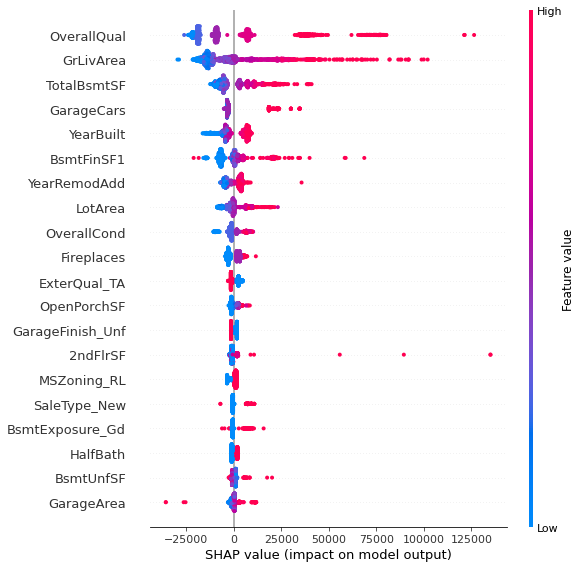

In [83]:
shap.summary_plot(shap_values, X)

Finding the best predictors for model

In [84]:
shap_vals_gb = pd.DataFrame(data = np.abs(shap_values), columns=X.columns)

In [85]:
shap_scores_gb = np.mean(shap_vals_gb).sort_values(ascending=False)

In [86]:
#getting predictors with shap score greater than 20
shap_scores_gb[shap_scores_gb.values > 20].index

Index(['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'YearBuilt',
       'BsmtFinSF1', 'YearRemodAdd', 'LotArea', 'OverallCond', 'Fireplaces',
       'ExterQual_TA', 'OpenPorchSF', 'GarageFinish_Unf', '2ndFlrSF',
       'MSZoning_RL', 'SaleType_New', 'BsmtExposure_Gd', 'HalfBath',
       'BsmtUnfSF', 'GarageArea', 'KitchenQual_TA', 'WoodDeckSF', 'MoSold',
       'GarageYrBlt', '1stFlrSF', 'ScreenPorch', 'Exterior1st_BrkFace',
       'SaleCondition_Normal', 'MasVnrArea', 'Neighborhood_Crawfor',
       'MSSubClass', 'BsmtExposure_No', 'Functional_Typ', 'Foundation_PConc',
       'SaleCondition_Partial', 'CentralAir_Y', 'MSZoning_RM', 'LotShape_Reg',
       'Condition1_Norm', 'Neighborhood_Edwards', 'Neighborhood_Somerst',
       'BsmtFinType1_GLQ', 'KitchenAbvGr', 'Neighborhood_StoneBr',
       'TotRmsAbvGrd', 'FullBath', 'BsmtFullBath', 'LotFrontage',
       'Condition1_RRAe', 'BedroomAbvGr', 'Neighborhood_BrkSide',
       'Neighborhood_NridgHt', 'PoolArea', 'Neighborhood_Cle

In [87]:
gbr_labels = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'YearBuilt',
       'BsmtFinSF1', 'YearRemodAdd', 'LotArea', 'OverallCond', 'Fireplaces',
       'ExterQual_TA', 'OpenPorchSF', 'SaleCondition_Partial',
       'GarageFinish_Unf', '2ndFlrSF', 'MSZoning_RL', 'BsmtExposure_Gd',
       'HalfBath', 'BsmtUnfSF', 'GarageArea', 'KitchenQual_TA', 'WoodDeckSF',
       'MoSold', 'GarageYrBlt', '1stFlrSF', 'ScreenPorch',
       'Exterior1st_BrkFace', 'SaleCondition_Normal', 'MasVnrArea',
       'Neighborhood_Crawfor', 'MSSubClass', 'BsmtExposure_No',
       'Functional_Typ', 'Foundation_PConc', 'CentralAir_Y',
       'Neighborhood_Edwards', 'MSZoning_RM', 'LotShape_Reg',
       'Condition1_Norm', 'Neighborhood_Somerst', 'BsmtFinType1_GLQ',
       'KitchenAbvGr', 'Neighborhood_StoneBr', 'TotRmsAbvGrd', 'FullBath',
       'BsmtFullBath', 'SaleType_New', 'LotFrontage', 'Condition1_RRAe',
       'BedroomAbvGr', 'PoolArea', 'Neighborhood_BrkSide',
       'Neighborhood_NridgHt', 'Neighborhood_ClearCr', 'EnclosedPorch',
       'LotConfig_CulDSac', 'Functional_Mod', 'SaleCondition_Family',
       'BsmtFinSF2', 'Condition2_Norm', 'Functional_Sev', 'Condition2_PosN']

In [88]:
#xgb shap
xgb = XGBRegressor(n_estimators = 200, min_child_weight = 3, max_depth = 4, learning_rate = 0.1, 
                   gamma = 0.2, colsample_bytree = 0.3)

In [89]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [90]:
score = xgb.score(X_test,y_test)

In [91]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

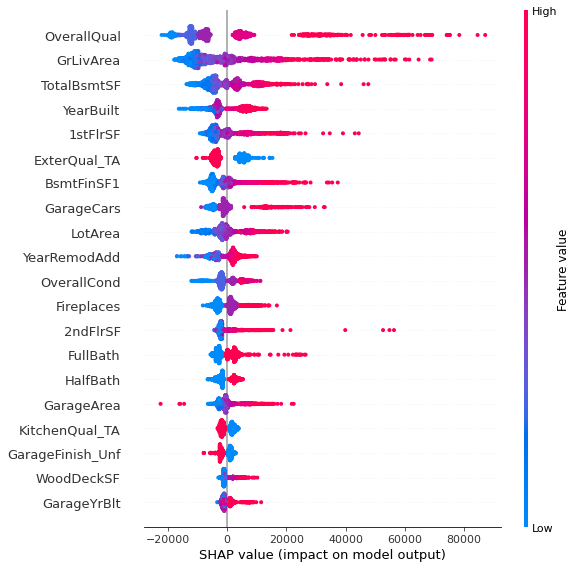

In [92]:
shap.summary_plot(shap_values, X, max_display=20)

In [93]:
print(score)

0.9030219168696704


In [94]:
#shap.dependence_plot(ind='GarageCars', shap_values=shap_values, features=X,interaction_index='GarageArea')

In [95]:
shap_vals_xgb = pd.DataFrame(data = np.abs(shap_values), columns=X.columns)

In [96]:
shap_scores_xgb = np.mean(shap_vals_xgb).sort_values(ascending=False)

In [97]:
shap_scores_xgb = shap_scores_xgb[shap_scores_xgb.values > 60]

In [98]:
#getting predictors with shap score greater than 20
shap_scores_xgb.index.values

array(['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', '1stFlrSF',
       'ExterQual_TA', 'BsmtFinSF1', 'GarageCars', 'LotArea',
       'YearRemodAdd', 'OverallCond', 'Fireplaces', '2ndFlrSF',
       'FullBath', 'HalfBath', 'GarageArea', 'KitchenQual_TA',
       'GarageFinish_Unf', 'WoodDeckSF', 'GarageYrBlt', 'OpenPorchSF',
       'KitchenQual_Gd', 'MoSold', 'BsmtExposure_No', 'BsmtExposure_Gd',
       'SaleCondition_Normal', 'BsmtFullBath', 'TotRmsAbvGrd',
       'Foundation_CBlock', 'Functional_Typ', 'MSSubClass', 'ScreenPorch',
       'YrSold', 'Neighborhood_Crawfor', 'LotShape_Reg',
       'BsmtFinType1_GLQ', 'BsmtUnfSF', 'MSZoning_RL', 'MasVnrArea',
       'HouseStyle_2Story', 'SaleType_New', 'Condition1_Norm',
       'BsmtQual_Gd', 'Exterior1st_BrkFace', 'KitchenAbvGr',
       'Neighborhood_Somerst', 'LotFrontage', 'MSZoning_RM',
       'CentralAir_Y', 'GarageType_Attchd', 'Neighborhood_OldTown',
       'LotConfig_CulDSac', 'LotConfig_Inside', 'Neighborhood_Edwards',
   

In [99]:
xgb_labels = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', '1stFlrSF',
       'ExterQual_TA', 'BsmtFinSF1', 'GarageCars', 'LotArea',
       'YearRemodAdd', 'OverallCond', 'Fireplaces', '2ndFlrSF',
       'FullBath', 'HalfBath', 'GarageArea', 'KitchenQual_TA',
       'GarageFinish_Unf', 'WoodDeckSF', 'GarageYrBlt', 'OpenPorchSF',
       'KitchenQual_Gd', 'MoSold', 'BsmtExposure_No', 'BsmtExposure_Gd',
       'SaleCondition_Normal', 'BsmtFullBath', 'TotRmsAbvGrd',
       'Foundation_CBlock', 'Functional_Typ', 'MSSubClass', 'ScreenPorch',
       'YrSold', 'Neighborhood_Crawfor', 'LotShape_Reg',
       'BsmtFinType1_GLQ', 'BsmtUnfSF', 'MSZoning_RL', 'MasVnrArea',
       'HouseStyle_2Story', 'SaleType_New', 'Condition1_Norm',
       'BsmtQual_Gd', 'Exterior1st_BrkFace', 'KitchenAbvGr',
       'Neighborhood_Somerst', 'LotFrontage', 'MSZoning_RM',
       'CentralAir_Y', 'GarageType_Attchd', 'Neighborhood_OldTown',
       'LotConfig_CulDSac', 'LotConfig_Inside', 'Neighborhood_Edwards',
       'BsmtHalfBath', 'Neighborhood_NridgHt', 'Neighborhood_BrkSide',
       'Foundation_PConc', 'BsmtFinType1_Unf', 'BedroomAbvGr',
       'LotConfig_FR2', 'BsmtFinSF2', 'PavedDrive_Y', 'LandContour_Lvl',
       'SaleCondition_Partial', 'Neighborhood_StoneBr', 'EnclosedPorch',
       'HouseStyle_1Story', 'GarageType_Detchd', 'ExterCond_TA',
       'Condition1_RRAe', 'HeatingQC_Gd', 'PoolArea', 'ExterQual_Gd',
       'Neighborhood_ClearCr', 'Exterior2nd_HdBoard',
       'Exterior1st_HdBoard', 'GarageQual_Gd', 'SaleType_WD',
       'GarageType_CarPort', 'Exterior1st_MetalSd', 'Neighborhood_NWAmes',
       'Exterior1st_VinylSd']

# Training Model on top 20 RF predictors

In [100]:
#top 20 predictor labels
X_rf = X[top_20_rf]
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size=0.25, random_state=42)
rf.fit(X_train,y_train)
predictions=rf.predict(X_test)
print(metrics.mean_absolute_error(predictions,y_test))

17971.752551020407


In [101]:
#top 20 predictor labels
X_rf = X[top_20_rf]

In [102]:
df_test.isna().sum()

Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       227
LotArea             0
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         16
MasVnrArea         15
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           44
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinSF1          1
BsmtFinType2       42
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFin

# Preprocessing of test dataset

In [103]:
#preprocessing

df_test['Alley'] = df_test['Alley'].fillna(value='None')
df_test.drop(columns='PoolQC', axis=1, inplace=True)
df_test['Fence'] = df_test['Fence'].fillna(value='None')
df_test.drop(columns='MiscFeature',axis=1,inplace=True)
df_test.drop(columns='FireplaceQu',axis=1,inplace=True)
df_test.drop(labels='Id',axis=1,inplace=True)

In [104]:
df_test.shape

(1459, 76)

In [105]:
df_test.select_dtypes(include='object').columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

In [106]:
#First get dummies from text columns
df_test = pd.get_dummies(data=df_test,columns=['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'], drop_first=True)

In [107]:
df_test.shape

(1459, 222)

In [108]:
df_test_X = df_test[top_20_rf]

In [109]:
df_test_X.isna().sum()

OverallQual           0
GrLivArea             0
TotalBsmtSF           1
BsmtFinSF1            1
1stFlrSF              0
YearBuilt             0
LotArea               0
GarageCars            1
GarageArea            1
2ndFlrSF              0
YearRemodAdd          0
Fireplaces            0
OverallCond           0
FullBath              0
GarageFinish_Unf      0
OpenPorchSF           0
GarageYrBlt          78
GarageType_Detchd     0
WoodDeckSF            0
TotRmsAbvGrd          0
dtype: int64

In [110]:
#no basement
df_test_X[df_test['TotalBsmtSF'].isna()]

,OverallQual,GrLivArea,TotalBsmtSF,BsmtFinSF1,1stFlrSF,YearBuilt,LotArea,GarageCars,GarageArea,2ndFlrSF,YearRemodAdd,Fireplaces,OverallCond,FullBath,GarageFinish_Unf,OpenPorchSF,GarageYrBlt,GarageType_Detchd,WoodDeckSF,TotRmsAbvGrd
660,4,896,NaN,NaN,896,1946,5940,1.0,280.0,0,1950,0,7,1,1,0,1946.0,1,0,4


In [111]:
#no garage
df_test_X[df_test['GarageCars'].isna()]

,OverallQual,GrLivArea,TotalBsmtSF,BsmtFinSF1,1stFlrSF,YearBuilt,LotArea,GarageCars,GarageArea,2ndFlrSF,YearRemodAdd,Fireplaces,OverallCond,FullBath,GarageFinish_Unf,OpenPorchSF,GarageYrBlt,GarageType_Detchd,WoodDeckSF,TotRmsAbvGrd
1116,5,1828,859.0,548.0,942,1923,9060,NaN,NaN,886,1999,0,6,2,0,0,NaN,1,174,6


In [112]:
#no garage, except for 1 
df_test_X[df_test['GarageYrBlt'].isna()]['GarageArea'].value_counts()

0.0      76
360.0     1
Name: GarageArea, dtype: int64

In [113]:
df_test_X[(df_test['GarageYrBlt'].isna()) & (df_test['GarageArea'] == 360.0)]

,OverallQual,GrLivArea,TotalBsmtSF,BsmtFinSF1,1stFlrSF,YearBuilt,LotArea,GarageCars,GarageArea,2ndFlrSF,YearRemodAdd,Fireplaces,OverallCond,FullBath,GarageFinish_Unf,OpenPorchSF,GarageYrBlt,GarageType_Detchd,WoodDeckSF,TotRmsAbvGrd
666,6,1984,1242.0,196.0,1242,1910,8094,1.0,360.0,742,1983,0,8,2,0,0,NaN,1,64,8


In [114]:
df_test_X.loc[df_test_X.index==666, 'GarageYrBlt'] = 1983


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [115]:
df_test_X.fillna(value=0, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [116]:
df_test_X.head()

,OverallQual,GrLivArea,TotalBsmtSF,BsmtFinSF1,1stFlrSF,YearBuilt,LotArea,GarageCars,GarageArea,2ndFlrSF,YearRemodAdd,Fireplaces,OverallCond,FullBath,GarageFinish_Unf,OpenPorchSF,GarageYrBlt,GarageType_Detchd,WoodDeckSF,TotRmsAbvGrd
0,5,896,882.0,468.0,896,1961,11622,1.0,730.0,0,1961,0,6,1,1,0,1961.0,0,140,5
1,6,1329,1329.0,923.0,1329,1958,14267,1.0,312.0,0,1958,0,6,1,1,36,1958.0,0,393,6
2,5,1629,928.0,791.0,928,1997,13830,2.0,482.0,701,1998,1,5,2,0,34,1997.0,0,212,6
3,6,1604,926.0,602.0,926,1998,9978,2.0,470.0,678,1998,1,6,2,0,36,1998.0,0,360,7
4,8,1280,1280.0,263.0,1280,1992,5005,2.0,506.0,0,1992,0,5,2,0,82,1992.0,0,0,5


In [117]:
#it works, but not very accurate. I could try to train on a model that uses all fo the labels
predictions = rf.predict(df_test_X)

# RF on all labels

In [118]:
#preprocessing
df_test.isna().sum()


MSSubClass                 0
LotFrontage              227
LotArea                    0
OverallQual                0
OverallCond                0
YearBuilt                  0
YearRemodAdd               0
MasVnrArea                15
BsmtFinSF1                 1
BsmtFinSF2                 1
BsmtUnfSF                  1
TotalBsmtSF                1
1stFlrSF                   0
2ndFlrSF                   0
LowQualFinSF               0
GrLivArea                  0
BsmtFullBath               2
BsmtHalfBath               2
FullBath                   0
HalfBath                   0
BedroomAbvGr               0
KitchenAbvGr               0
TotRmsAbvGrd               0
Fireplaces                 0
GarageYrBlt               78
GarageCars                 1
GarageArea                 1
WoodDeckSF                 0
OpenPorchSF                0
EnclosedPorch              0
3SsnPorch                  0
ScreenPorch                0
PoolArea                   0
MiscVal                    0
MoSold        

In [119]:
df_test['PoolArea'].value_counts()

0      1453
144       1
228       1
368       1
444       1
561       1
800       1
Name: PoolArea, dtype: int64

In [120]:
#we can drop poolqc and fill every other na with 0 with the exception of the row we found earlier in the 
#20 feature rf model

In [121]:
df_test.loc[df_test_X.index==666, 'GarageYrBlt'] = 1983

In [122]:
df_test.fillna(value=0, inplace=True)

In [123]:
#train an rf model with the labels that match df_test
X_train, X_test, y_train, y_test = train_test_split(X[rf_labels], y, test_size=0.25, random_state=42)

In [124]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=40, n_estimators=200)

In [125]:
predictions = rf.predict(df_test[rf_labels])

Using the random forest regressor with the top 20 predictors according to shap values, the RMSLE was .15472
With the top 78 predictors, the improvement was minimal to .15330
The random forest regressor was the least accurate of three regressors I tried according to the initial comparison run, but there are changes I could make in data preprocessing and possibly in the hyper-parameter turning as well for a better score using this method.

# GradientBoosting Test

For the gradient boosting test I will need to check the variables for collinearity, something that random forests was good at eliminating naturally. I could try training a model on the same predictors first to see how effective it is. I can also do a test submission on the model without checking the variables for collinearity.

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X[gbr_labels], y, test_size=0.25, random_state=42)

In [127]:
gbr.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, min_samples_split=10, n_estimators=200)

In [128]:
#predictions without checking for collinearity
predictions = gbr.predict(df_test[gbr_labels])

The submission without accounting for possibly collinear variables scored .14110, which is a good improvement over the random forest regressor. Next submission will refine the predictors used.

In [129]:
#X[gbr_labels].corr()

# XGBoost Test

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X[xgb_labels], y, test_size=0.25, random_state=42)

In [131]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [132]:
predictions = xgb.predict(df_test[xgb_labels])

The predictions using XGBoost regressor without adjusting for collinearity scored .12896, which is a significant improvement over the Gradient Boost regressor unadjusted. The rest of my effort will be directed towards improving this model

# ML Model Test

In [133]:
#primary hyperparamters of neural networks
model_info = {}
model_info['Hidden layers'] = [100] * 6
#model_info['Input size'] = og_one_hot.shape[1] - 1
model_info['Activations'] = ['relu'] * 6
model_info['Optimization'] = 'adadelta'
model_info["Learning rate"] = .005
model_info["Batch size"] = 32
model_info["Preprocessing"] = 'Standard'
model_info["Lambda"] = 0
#model_2['Regularization'] = 'l2'
#model_2['Reg param'] = 0.0005